## Đọc dữ liệu

In [1]:
!wget -qO- https://drive.google.com/uc?id=1CQGfuhXwF4_n5wwXvHpO0LamDZto1FZg > AccData2010-2019.csv
!wget -qO- https://drive.google.com/uc?id=1kRl2tb8-mwlwjWztDo1LHFvNHPwqhd-R > VehData2010-2019.csv
!wget -qO- https://drive.google.com/uc?id=1W9quuJ6x1fK05BQKRoanUjS8d72FDfcI > CasData2010-2019.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
accident_df = pd.read_csv('AccData2010-2019.csv')
vehicle_df = pd.read_csv('VehData2010-2019.csv')
casualty_df = pd.read_csv('CasData2010-2019.csv')
accident_df.set_index('Accident Index',inplace = True)
vehicle_df.set_index('Accident Index',inplace = True)
casualty_df.set_index('Accident Index',inplace = True)

### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

In [4]:
accident_df.head()

,Year,Severity,NumberVehicles,NumberCasualties,OutputDate,Day,OutputTime,Easting,Northing,LocalAuthority,Road1Class,Road1Number,CarriagewayType,SpeedLimit,JunctionDetail,JunctionControl,Road2Class,Road2Number,PedCrossingHumanControl,PedCrossingPhysicalFacilities,LightingCondition,WeatherCondition,RoadSurface,SpecialConditions,CarriagewayHazard,PlaceReported
Accident Index,,,,,,,,,,,,,,,,,,,,,,,,,,
102262412010,2010,3,2,1,01/01/2010,6,13:10,382347,390025,102,5,5166,3,50,6,2,3,5103,0,0,1,1,4,0,0,1
102262562010,2010,3,2,1,01/01/2010,6,11:10,381892,390582,102,7,0,6,30,3,4,7,0,0,0,1,1,4,0,0,1
102264322010,2010,3,2,1,01/01/2010,6,17:30,385840,403134,102,4,664,3,30,3,4,7,0,0,0,4,1,2,0,0,2
107264182010,2010,3,3,1,01/01/2010,6,13:49,377762,403302,107,4,666,3,30,3,4,1,60,0,0,3,9,1,0,0,2
114261842010,2010,3,1,1,01/01/2010,6,01:55,355982,404620,114,4,577,6,30,0,0,0,0,0,0,7,9,1,0,0,2


In [5]:
accident_df.shape

(40237, 26)

In [6]:
vehicle_df.head()

,Year,VehicleReferenceNumber,VehicleType,ArtTowing,Manoeuvre,VehicleLocationOffRoad,JunctionLocation,Skidding,HitObjectOnCWay,VehicleLeaveCWay,HitObjectOffCWay,FirstPointImpact,JourneyPurpose,ForeignReg,SexOfDriver,AgeBandOfDriver
Accident Index,,,,,,,,,,,,,,,,
1.002600e+11,2010,1,9,0,13,0,0,0,0,0,0,0,5,0,3,7
1.002600e+11,2010,2,17,0,18,0,0,0,0,0,0,0,5,0,3,7
1.002600e+11,2010,3,9,0,18,0,0,1,0,0,0,1,5,0,1,7
1.002600e+11,2010,4,9,0,18,0,0,0,0,0,0,1,5,0,1,6
1.002620e+11,2010,1,9,0,7,0,8,1,7,0,7,1,5,0,1,4


In [7]:
vehicle_df.shape

(75120, 16)

In [8]:
casualty_df.head()

,Year,VehicleReferenceNumber,CasualtyNumber,CasualtyClass,Sex,AgeBandOfCasualty,CasualtySeverity,PedLocation,PedMovement,CarPassenger,BusPassenger,PedInjWork,CasTypeCode
Accident Index,,,,,,,,,,,,,
1.002600e+11,2010,3,1,1,1,7,3,0,0,0,0,0,9
1.002600e+11,2010,4,2,1,1,6,3,0,0,0,0,0,9
1.002600e+11,2010,4,3,2,1,2,3,0,0,2,0,0,9
1.002600e+11,2010,4,4,2,2,1,3,0,0,2,0,0,9
1.002620e+11,2010,1,1,1,1,4,3,0,0,0,0,0,9


In [9]:
casualty_df.shape

(55525, 13)

### Dữ liệu có các dòng bị lặp không? 

In [10]:
have_duplicated_rows = False if accident_df.duplicated().sum() == 0 else True
have_duplicated_rows

False

In [11]:
have_duplicated_rows = False if vehicle_df.duplicated().sum() == 0 else True
have_duplicated_rows

True

In [12]:
vehicle_df = vehicle_df[vehicle_df.duplicated() == False] #Xoa cac dong co gia tri lam
vehicle_df.shape

(50869, 16)

In [13]:
have_duplicated_rows = False if casualty_df.duplicated().sum() == 0 else True
have_duplicated_rows

True

In [14]:
casualty_df = casualty_df[casualty_df.duplicated() == False]
casualty_df.shape

(16585, 13)

### Mỗi cột có ý nghĩa gì?

**Với accident_df:**
- Severity: mức độ nghiêm trọng (1: Fatal, 2: Serious, 3: slight)
- NumberVehicles: số lượng phương tiện trong 1 vụ tai nạn.
- NumberCasualties: số lượng người chết trong 1 vụ tai nạn.
- OutputDate: thời điểm xảy ra vụ tai nạn (ngày/tháng/năm)
- OutputTime: thời gian xảy ra vụ tai nạn (giờ:phút)
- Easting, Northing: tọa độ của vụ tai nạn.
- LocalAuthority: Chính quyền sở tại 
- CarriagewayType: Loại đường
- SpeedLimit: tốc độ giới hạn.
- PedCrossingHumanControl: người điều phối giao thông
- JunctionDetail: tuyến đường giao nhau.
- JunctionControl: Kiểm soát các tuyến đường giao nhau (1: người được ủy quyền, 2: đèn tín hiệu giao thông, 3: đèn báo dừng, 4: Nhường đường hoặc không kiểm soát).
- PedCrossingPhysicalFacilities: Cơ sở vật chất dành cho người đi bộ băng qua đường.
- LightingCondition: điều kiện chiếu sáng.
- WeatherCondition: điều kiện thời tiết.
- RoadSurface: Điều kiện bề mặt đường.
- SpecialConditions: điều kiện đặc biệt(1: đèn tín hiệu bị tắt, 2: đèn tín hiệu bị lỗi 1 phần, 3: Ký hiệu đường hoặc đánh dấu ngã ba bị lỗi hoặc bị che khuất, ...)
- CarriagewayHazard: Nguy hiểm trên đường.
- PlaceReported: cảnh sát có tham gia hiện trường vụ tai nạn không?

**Với vehicle_df:**

- VehicleType: loại phương tiện tham gia giao thông.
- ArtTowing: kiểu dáng của xe.
- Manoeuvre: động cơ.
- VehicleLocationOffRoad: vị trí chức năng của xe.
- JunctionLocation: tuyến đường giao nhau.
- Skidding: trượt và quay lại.
- HitObjectOnCWay: Vật tông trúng trên tường
- FirstPointImpact: điểm tác động đầu tiên của xe khi va chạm.
- JourneyPurpose: mục đích hành trình của người lái xe.
- ForeignReg: Phương tiện giao thông ngoại quốc được đăng ký.
- SexOfDriver: giới tính của người gây ra tai nạn giao thông.
- AgeBandOfDriver: độ tuổi người lái xe gây ra tai nạn. 

### Mỗi cột hiện đang có kiểu dữ liệu gì?

In [15]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40237 entries, 102262412010 to 112671202019
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Year                           40237 non-null  int64 
 1   Severity                       40237 non-null  int64 
 2   NumberVehicles                 40237 non-null  int64 
 3   NumberCasualties               40237 non-null  int64 
 4   OutputDate                     40237 non-null  object
 5   Day                            40237 non-null  int64 
 6   OutputTime                     40237 non-null  object
 7   Easting                        40237 non-null  int64 
 8   Northing                       40237 non-null  int64 
 9   LocalAuthority                 40237 non-null  int64 
 10  Road1Class                     40237 non-null  int64 
 11  Road1Number                    40237 non-null  int64 
 12  CarriagewayType                40237 non-n

In [16]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 50869 entries, 100260000000.0 to 114682000000.0
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Year                    50869 non-null  int64
 1   VehicleReferenceNumber  50869 non-null  int64
 2   VehicleType             50869 non-null  int64
 3   ArtTowing               50869 non-null  int64
 4   Manoeuvre               50869 non-null  int64
 5   VehicleLocationOffRoad  50869 non-null  int64
 6   JunctionLocation        50869 non-null  int64
 7   Skidding                50869 non-null  int64
 8   HitObjectOnCWay         50869 non-null  int64
 9   VehicleLeaveCWay        50869 non-null  int64
 10  HitObjectOffCWay        50869 non-null  int64
 11  FirstPointImpact        50869 non-null  int64
 12  JourneyPurpose          50869 non-null  int64
 13  ForeignReg              50869 non-null  int64
 14  SexOfDriver             50869 non-null  int64


In [17]:
casualty_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 16585 entries, 100260000000.0 to 114668000000.0
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Year                    16585 non-null  int64
 1   VehicleReferenceNumber  16585 non-null  int64
 2   CasualtyNumber          16585 non-null  int64
 3   CasualtyClass           16585 non-null  int64
 4   Sex                     16585 non-null  int64
 5   AgeBandOfCasualty       16585 non-null  int64
 6   CasualtySeverity        16585 non-null  int64
 7   PedLocation             16585 non-null  int64
 8   PedMovement             16585 non-null  int64
 9   CarPassenger            16585 non-null  int64
 10  BusPassenger            16585 non-null  int64
 11  PedInjWork              16585 non-null  int64
 12  CasTypeCode             16585 non-null  int64
dtypes: int64(13)
memory usage: 1.8 MB


## 1. Phân tích mối liên hệ giữa các vụ tai nạn giao thông trong các khoảng thời gian khác nhau

Đầu tiên, ta xét các cột dữ liệu ngày tháng năm, nhằm tìm hiểu xem có sự liên quan nào giữa số vụ tai nạn tại các thời điểm khác nhau hay không.

In [18]:
s = accident_df.loc[:,'Year'].groupby(accident_df['Year']).count()
accident_year_df = s.to_frame().rename(columns = {'Year': 'Accident count'}, inplace = False).reset_index()
accident_year_df

,Year,Accident count
0,2010,5444
1,2011,5127
2,2012,4378
3,2013,3861
4,2014,4004
5,2015,3073
6,2016,2906
7,2017,4066
8,2018,3761
9,2019,3617


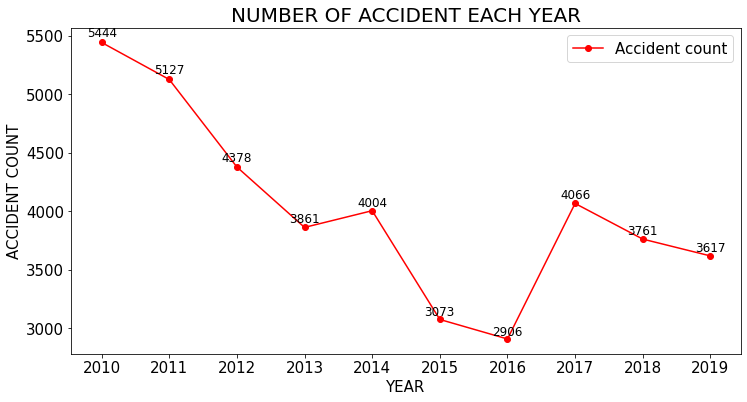

In [19]:
fig, ax = plt.subplots(figsize = (12,6))
x = np.arange(accident_year_df['Year'].shape[0])
Q1_bar = ax.plot(x, accident_year_df['Accident count'],color = 'r',marker='o')
plt.xticks(x,accident_year_df['Year'], size=15)
plt.yticks(size=15)
plt.title('NUMBER OF ACCIDENT EACH YEAR',size = 20)
plt.xlabel('YEAR', fontsize=15)
plt.ylabel('ACCIDENT COUNT', fontsize= 15)
plt.legend(['Accident count'], fontsize =15,loc ='upper right')
for i, v in enumerate(accident_year_df['Accident count']):
    ax.text(i,1.01*v, "%d" %v, ha="center",fontsize=12)
plt.show()

**Insight (1)**: Nhìn chung thì qua các năm, tổng số vụ tai nạn mỗi năm đang có xu hướng giảm.
- Có một chút biến động vào giai đoạn 2015 - 2016 rằng, số trường hợp tai nạn giảm mạnh, thấp nhất là 2906 vụ năm 2016, sau đó trở về trạng thái ban đầu vào năm 2017 và nhìn chung thì tiếp tục giảm vào các năm tiếp theo.
- Trong vòng 10 năm từ 2010 đến 2019, số ca tai nạn giảm lên tới hơn 150%, từ 5444 vụ năm 2010 xuống còn 3617 vụ năm 2019.

Ta phân tích rõ hơn dữ liệu tai nạn này vào các tháng trong từng năm.

In [20]:
accidents = accident_df.copy()
accidents['OutputDate'] = pd.to_datetime(accidents['OutputDate'])

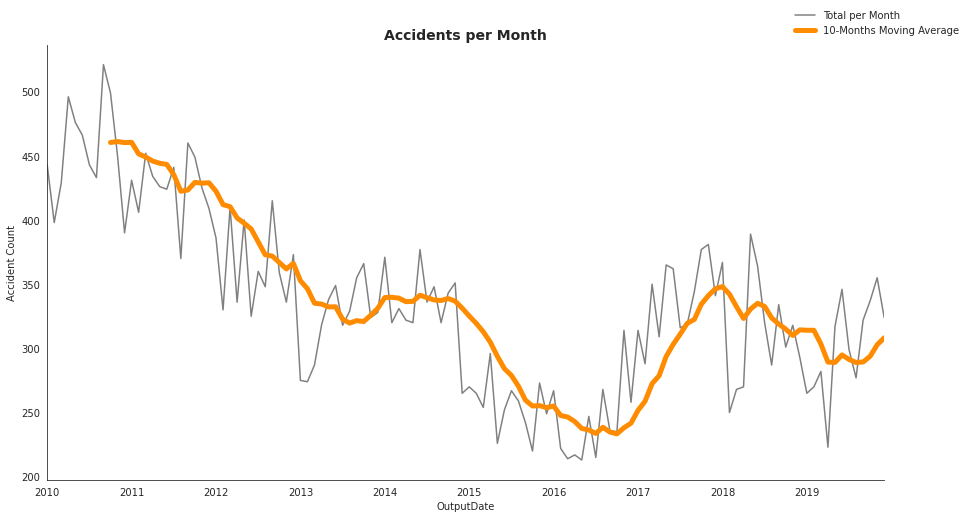

In [21]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,8))
# plot
accidents.reset_index().set_index('OutputDate').resample('M').size().plot(label='Total per Month', color='grey', ax=ax)
accident_10_months = accidents.reset_index().set_index('OutputDate').resample('M').size().rolling(window=10).mean()
accident_10_months.plot(color='darkorange', linewidth=5, label='10-Months Moving Average', ax=ax)
ax.set_title('Accidents per Month', fontsize=14, fontweight='bold')
ax.set(ylabel='Accident Count')
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False);

**Nhận xét:**
- Nhìn chung thì số liệu số ca tai nạn xảy ra giữa các tháng trong năm là không đồng đều, biến thiên rất lớn giữa các tháng và các quý trong năm.
- Thời điểm đầu năm và cuối năm ghi nhận nhiều trường hợp tai nạn hơn bình thường so với các khoảng thời gian còn lại.
 
Ta tiếp tục phân tích xem việc phân bố số vụ tai nạn kể trên có đồng đều nhau giữa các năm hay không.

In [22]:
accident_df['Month'] = accident_df['OutputDate'].apply(lambda x: x[3:5])
s = accident_df.reset_index().groupby(['Year', 'Month']).agg({'Accident Index':'nunique','NumberCasualties':'sum'}).reset_index('Year').groupby('Month').mean()[['Accident Index', 'NumberCasualties']]
accident_month_df = s.rename(columns = {'Accident Index': 'Average of Accident account','NumberCasualties':'Average of Casualties Count'}, inplace = False).reset_index()
accident_month_df

,Month,Average of Accident account,Average of Casualties Count
0,01,320.5,440.2
1,02,303.3,422.7
2,03,329.3,462.3
3,04,306.8,419.0
4,05,350.3,485.7
5,06,347.0,481.0
6,07,330.7,459.9
7,08,308.4,433.3
8,09,347.2,475.1
9,10,367.6,503.0


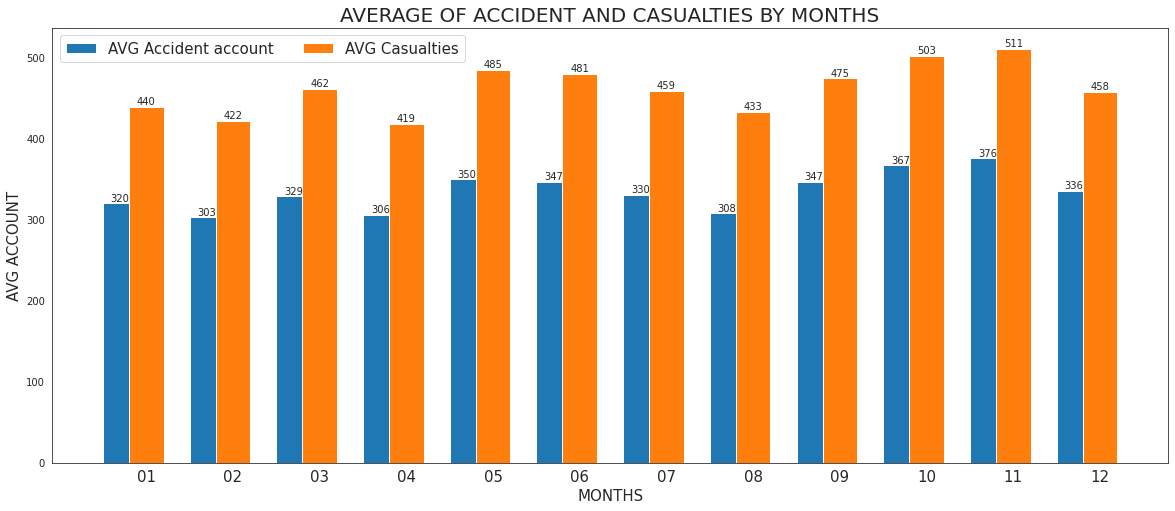

In [23]:
fig, ax = plt.subplots(figsize = (20,8))
x = np.arange(accident_month_df.shape[0])
Q1_bar = ax.bar(x-0.3, accident_month_df['Average of Accident account'],width = 0.4)
Q2_bar = ax.bar(x, accident_month_df['Average of Casualties Count'],width = 0.4)
plt.xticks(x, accident_month_df['Month'],size =15)
plt.title('AVERAGE OF ACCIDENT AND CASUALTIES BY MONTHS',size = 20)
plt.xlabel('MONTHS', fontsize=15)
plt.ylabel('AVG ACCOUNT', fontsize= 15)
plt.legend((Q1_bar,Q2_bar), ('AVG Accident account','AVG Casualties'), loc = 'upper left', ncol =2, fontsize = 15)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,'%d' % int(height),
                ha='center', va='bottom')
autolabel(Q1_bar)
autolabel(Q2_bar)
plt.show()

**Nhận xét:**
- Ta thấy sự biến thiên mạnh mẽ như ở đồ thị trước không còn xuất hiện trong biểu đồ này sau khi quan sát dưới góc độ các tháng trong năm. 
- Tuy nhiên, giai đoạn cuối năm (quý 4) có vẻ tỉ lệ tai nạn vẫn cao hơn và độ nghiêm trọng cũng lớn hơn (thương vong nhiều hơn) so với khoảng thời gian còn lại. 

## 2. Phân tích thời điểm trong ngày thường hay xảy ra tai nạn

In [24]:
accident_df['OutputTime'] = accident_df['OutputTime'].apply(lambda x: x[:2])
s = accident_df.reset_index().groupby('OutputTime')['Accident Index'].agg(lambda x: x.nunique())
accident_time_df = s.to_frame().rename(columns = {'Accident Index': 'Accident account'}, inplace = False).reset_index()

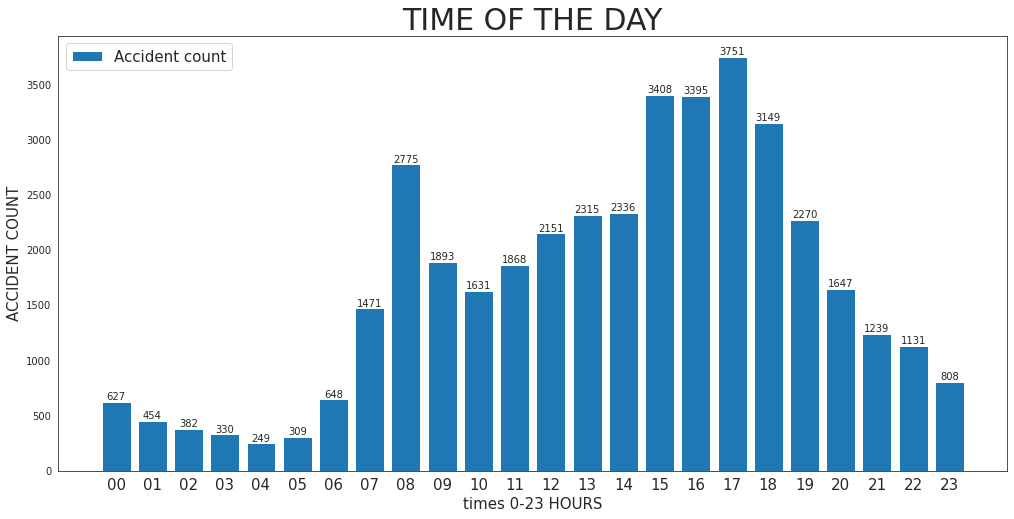

In [25]:
fig, ax = plt.subplots(figsize = (17,8))
x = np.arange(accident_time_df.shape[0])
Q1_bar = ax.bar(x, accident_time_df['Accident account'])
plt.xticks(x, accident_time_df['OutputTime'],size =15)
plt.title('TIME OF THE DAY',size = 30)
plt.xlabel('times 0-23 HOURS', fontsize=15)
plt.ylabel('ACCIDENT COUNT', fontsize= 15)
plt.legend(['Accident count'], fontsize =15,loc ='upper left')
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,'%d' % int(height),
                ha='center', va='bottom')
autolabel(Q1_bar)
plt.show()

**Insight(2):** Tai nạn chủ yếu xảy ra vào ban ngày và nhất là tập trung vào những lúc giờ cao điểm.
 
- Thời gian thường xuyên xảy ra tai nạn nhất là từ 15h -18h.
- Thường nằm trong khoảng thời gian đi làm vào buổi sáng, và khi tan ca vào buổi chiều. Các thời điểm này sẽ có nhiều phương tiện tham gia giao thông hơn, đồng nghĩa với việc rủi ro tai nạn cũng cao hơn.


## 3. Phân tích tình hình tai nạn giao thông dựa trên độ tuổi

In [26]:
s = vehicle_df.reset_index().groupby('AgeBandOfDriver')['Accident Index'].count()
age_drive_accident = pd.to_numeric(s, downcast= 'signed').to_frame().rename(columns= {'Accident Index': 'Accident Driver'}).reset_index()
age_casuality_df = casualty_df.reset_index().groupby('AgeBandOfCasualty')['Accident Index'].count()
age_drive_accident['Accident Casuality'] = age_casuality_df
age_drive_accident.fillna(0, inplace = True)
age_drive_accident['Accident Driver'] = age_drive_accident['Accident Driver'].apply(lambda x: x/10)
age_drive_accident

,AgeBandOfDriver,Accident Driver,Accident Casuality
0,0,297.6,0.0
1,1,2.4,783.0
2,2,24.5,1047.0
3,3,49.8,1380.0
4,4,346.6,1869.0
5,5,561.0,1924.0
6,6,1349.8,2642.0
7,7,953.8,1977.0
8,8,765.3,1785.0
9,9,445.8,1390.0


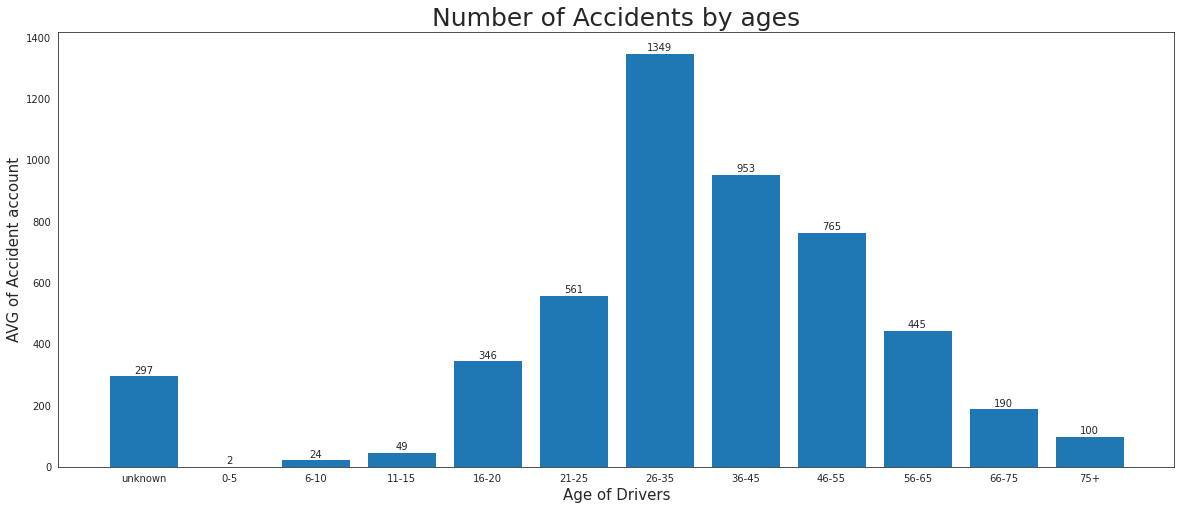

In [27]:
objects = ['unknown','0-5','6-10','11-15','16-20','21-25','26-35',
          '36-45', '46-55','56-65','66-75','75+']
fig, ax = plt.subplots(figsize = (20,8))
x = np.arange(age_drive_accident.shape[0])
Q1_bar = ax.bar(x, age_drive_accident['Accident Driver'])
plt.title('Number of Accidents by ages', fontsize = 25)
plt.grid(False)
y_pos = np.arange(len(objects))
plt.xticks(age_drive_accident['AgeBandOfDriver'] , objects)
plt.ylabel('AVG of Accident account' , fontsize = 15)
plt.xlabel('Age of Drivers', fontsize = 15,)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,'%d' % int(height),
                ha='center', va='bottom')
autolabel(Q1_bar)

**Insight(3):**  Các nhóm tuổi khác nhau thì có số vụ gây tai nạn khác nhau, thấp nhất ở lứa tuổi trẻ em và tuổi vị thành niên, sau đó tăng dần và mạnh lên đến cực đại ở nhóm tuổi 26-35 và sau đó thì giảm dần.

- Nguyên nhân chủ yếu dẫn đến hiện tượng trên bởi vì do tỉ lệ dân số giữa các nhóm là khác nhau, nhóm dân số có tuổi từ 26-55 vừa chiếm phần đông, đồng thời cũng là nhóm tuổi lao động chính của xã hội nên họ phải di chuyển nhiều hơn, dẫn đến xảy ra tai nạn nhiều hơn các nhóm khác là điều khó tránh khỏi. 

- Các nhóm nhỏ tuổi ít gây ra tai nạn bởi vì thường thì nhóm này chưa có quyền tham gia điều khiển giao thông, đồng thời các phương tiện giao thông đơn giản như xe đạp thường an toàn và ít có thể gây tai nạn.

- Độ tuổi từ 26-35 xảy ra số vụ tai nạn giao thông là nhiều nhất, lên tới hơn 2200 ca/năm, gấp 1.5 lần so với nhóm đứng thứ 2 là nhóm 36-45 tuổi với 1400 ca/năm. 

- Càng về cao tuổi thì số vụ tai nạn giao thông càng giảm dần, nguyên nhân chính là do vừa có sự giảm dần về số lượng và cả nhu cầu đi lại.

##4. Phân tích mức độ nghiêm trọng của tai nạn giao thông dựa trên giới tính

In [28]:
sex = {'sex': ['Male','Female','Unknown'],
        'SexOfDriver': [1,2,3]}
sex_df = pd.DataFrame(sex, columns = ['SexOfDriver', 'sex']).set_index('SexOfDriver')

In [29]:
sex_driver_vehicle_df = vehicle_df['SexOfDriver'].groupby(vehicle_df['SexOfDriver']).count()
sex_driver_vehicle_df = sex_driver_vehicle_df.to_frame().rename(columns = {'SexOfDriver':'Accident vehicle'},inplace = False)
sex_driver_vehicle_df['Accident casualty'] = casualty_df['Sex'].groupby(casualty_df['Sex']).count()

sex_driver_vehicle_df['Accident casualty'].fillna(0,inplace = True)

sex_driver_vehicle_df = sex_driver_vehicle_df.join(sex_df)
sex_driver_vehicle_df.reset_index(inplace = True)
sex_driver_vehicle_df

,SexOfDriver,Accident vehicle,Accident casualty,sex
0,1,33914,9442.0,Male
1,2,13894,7143.0,Female
2,3,3061,0.0,Unknown


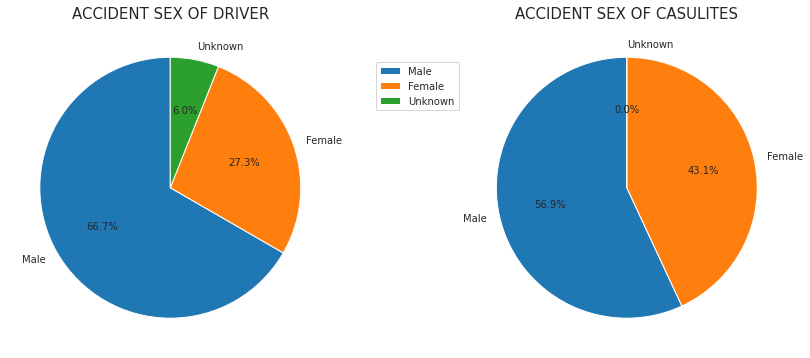

In [30]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 6)
ax[0].pie(sex_driver_vehicle_df['Accident vehicle'], labels=sex_driver_vehicle_df['sex'], autopct='%1.1f%%', startangle=90)
ax[0].set_title('ACCIDENT SEX OF DRIVER',size = 15)
ax[0].legend(sex_driver_vehicle_df['sex'], bbox_to_anchor=(1.4, 0.9))
ax[1].pie(sex_driver_vehicle_df['Accident casualty'], labels=sex_driver_vehicle_df['sex'], autopct='%1.1f%%', startangle=90)
ax[1].set_title('ACCIDENT SEX OF CASULITES',size = 15)
plt.show()

**Insight (4):** Tỉ lệ nam giới gây tai nạn và thương vong đều cao hơn so với nhóm nữ giới.  
- Tỉ lệ gây tai nạn của nam giới lên tới 65% cao gấp đôi nhóm thứ hai là nữ giới, đồng thời tỉ lệ thương vong của nam giới cũng lên tới 60% cao gấp 1.5 lần nữ giới. 
- Có thể thấy công việc liên quan đến việc điều khiển phương tiện tham gia giao thông phần lớn do nam giới đảm nhiệm, đồng thời vị trí tài xế xe cũng dễ thương vong hơn khi không may có tai nạn xảy ra.  
- Ngoài ra, các nhóm còn lại không trực tiếp tham gia điều khiển phương tiện giao thông, nhưng vẫn có tỉ lệ thương vong khá cao. 


In [31]:
a = vehicle_df.reset_index().groupby(['Year','SexOfDriver']).agg({'Accident Index':'count'})
a.reset_index(inplace = True)

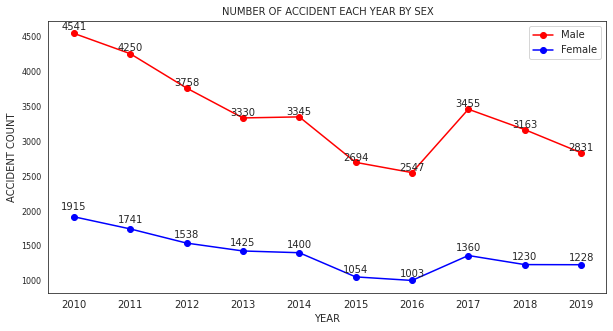

In [32]:
fig, ax = plt.subplots(figsize = (10,5))
x = np.arange(1,11)
Q1_bar = ax.plot(x, a[a['SexOfDriver']==1]['Accident Index'],color = 'r',marker='o')
Q2_bar = ax.plot(x, a[a['SexOfDriver']==2]['Accident Index'],color = 'blue',marker='o')
plt.xticks(x,np.arange(2010,2020), size=10)
plt.yticks(size=8)
plt.title('NUMBER OF ACCIDENT EACH YEAR BY SEX',size = 10)
plt.xlabel('YEAR', fontsize=10)
plt.ylabel('ACCIDENT COUNT', fontsize= 10)
plt.legend(['Male','Female'], fontsize =10,loc ='upper right')
for i, v in enumerate(a[a['SexOfDriver']==1]['Accident Index']):
    ax.text(i+1,1.01*v, "%d" %v, ha="center",fontsize=10)
for i, v in enumerate(a[a['SexOfDriver']==2]['Accident Index']):
    ax.text(i+1,1.05*v, "%d" %v, ha="center",fontsize=10)
plt.show()

**Nhận xét:**
- Có sự biến động vào giai đoạn 2015 - 2016, số trường hợp tai nạn giảm mạnh ở cả nam giới và nữ giới. Điển hình, ở nam giới  thấp nhất là 3576 vụ, còn ở nữ giới là 1465 vụ năm 2016 sau đó trở về trạng thái ban đầu vào năm 2017 và nhìn chung thì tiếp tục giảm vào các năm tiếp theo.
- Trong vòng 10 năm từ 2010 đến 2019, số ca tai nạn giảm lên tới 140%, từ 6822 vụ năm 2010 xuống còn 4180 vụ năm 2019 ở nam giới.
- Còn ở nữ giới, số ca tai nạn giảm lên tới 140%, từ 2915 vụ năm 2010 xuống còn 1754 vụ năm 2019.

##5. Điều kiện ngoại cảnh ảnh hưởng đến tai nạn

**Insight (5)**: Các vụ tai nạn giao thông chủ yếu xuất phát từ sự chủ quan của người điều khiển xe, chứ không phụ thuộc nhiều vào độ khắc nghiệt của điều kiện ngoại cảnh.  

Ta sẽ phân tích rõ sự chủ quan với các điều kiện ngoại cảnh gồm thời tiết và điều kiện mặt đường như ở dưới đây.

### Điều kiện thời tiết  

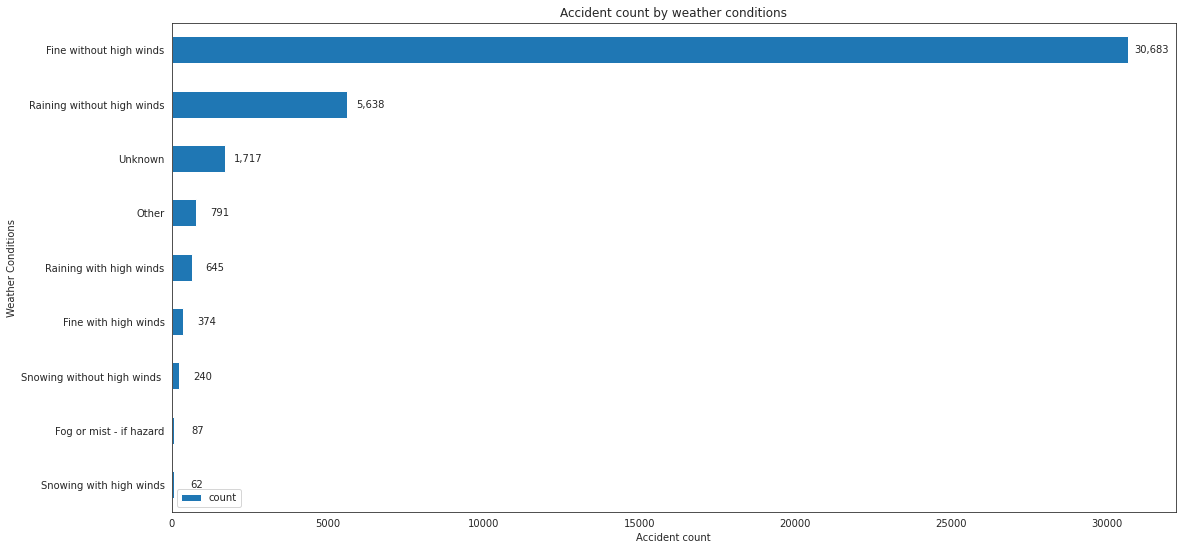

In [33]:
type_weather = {1:'Fine without high winds',
                2: 'Raining without high winds',
                3:'Snowing without high winds ',
                4:'Fine with high winds',
                5:'Raining with high winds',
                6:'Snowing with high winds',
                7:'Fog or mist - if hazard',
                8: 'Other',
                9: 'Unknown'
}

name_weather = pd.DataFrame(list(type_weather.items())).rename(columns = {0:'WeatherType',1:'Name type weather'}).set_index('WeatherType')
name_weather['count'] = accident_df['WeatherCondition'].value_counts().sort_index()
name_weather.set_index('Name type weather', drop=True, inplace=True)

ax = name_weather.sort_values('count').plot(kind='barh', figsize=(18, 9))

plt.xlabel('Accident count')
plt.ylabel('Weather Conditions')
plt.title('Accident count by weather conditions')
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds  
    ax.annotate(format(int(width), ','), xy=(left+width+750, bottom+height/2), 
                ha='center', va='center')   
plt.show()

**Nhận xét**: 

- Dữ liệu thống kê cho thấy điều kiện thời tiết tốt và không có gió lại có nhiều vụ tai nạn nhất, sau đó là trời mưa. Điều này cũng dễ hiểu bởi phần lớn thời tiết ở nước này là không có gió, nên dữ liệu thống kê chủ yếu ghi nhận được thông tin này.  
-  Đồng thời, trời mưa cũng ảnh hưởng đáng kể tới tình trạng tai nạn giao thông, nguyên nhân bởi mưa thì sẽ có tình trạng trơn trượt, mất lái xảy ra thường xuyên hơn.  
- Các điều kiện thời tiết nguy hiểm như nhiều gió, sương mù nguy hiểm nâng cao cảnh giác của người điều khiển phương tiện, cho nên họ sẽ di chuyển chậm hơn và sẽ ít gây tai nạn hơn đáng kể.



### Điều kiện mặt đường

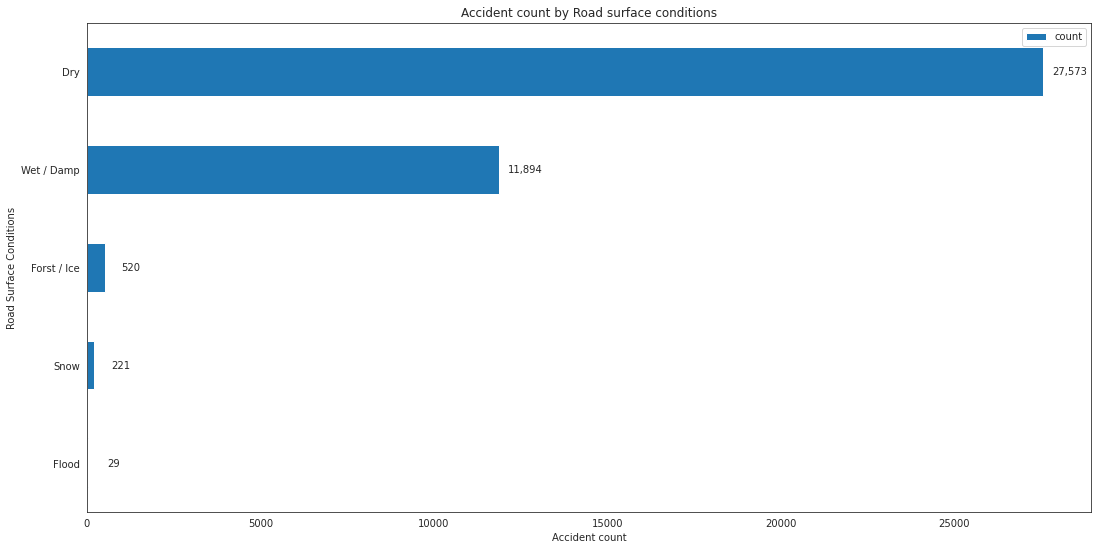

In [34]:
type_road_surface = {1:'Dry',
                2: 'Wet / Damp',
                3:'Snow',
                4:'Forst / Ice',
                5:'Flood' #  (surface water over 3cm deep)
}

name_road_surface = pd.DataFrame(list(type_road_surface.items())).rename(columns = {0:'RoadType',1:'Name type road'}).set_index('RoadType')
name_road_surface

name_road_surface['count'] = accident_df['RoadSurface'].value_counts().sort_index()
name_road_surface.set_index('Name type road', drop=True, inplace=True)

ax = name_road_surface.sort_values('count').plot(kind='barh', figsize=(18, 9))

plt.xlabel('Accident count')
plt.ylabel('Road Surface Conditions')
plt.title('Accident count by Road surface conditions')
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds  
    ax.annotate(format(int(width), ','), xy=(left+width+750, bottom+height/2), 
                ha='center', va='center')   
plt.show()

**Nhận xét**: Tương tự như điều kiện thời tiết, ta dễ dàng nhận thấy điều kiện mặt đường càng tốt thì lại xảy ra càng nhiều trường hợp tai nạn.  
- Mặt đường khô ráo nhưng lại ghi nhận nhiều vụ nhất, bởi vì một phần thời tiết ở đây chủ yếu là như vậy, một phần vì sự chủ quan của người lái xe.  
- Đường có nhiều nước, ẩm ướt cũng tương tự như thời tiết mưa kể trên - dễ trơn trợt, mất lái, tầm nhìn kém dẫn đến tai nạn.  
- Các điều kiện mặt đường nguy hiểm như băng tuyết, ngập nước ảnh hưởng nhiều đến tốc độ di chuyển của xe. đồng thời cũng khiến tài xế tập trung, cảnh giác hơn dẫn đến ít tai nạn xảy ra hơn.  

##6. Phân tích phân bố các vụ tai nạn giao thông

Trong phần này, ta sử dụng Power BI để trực quan vị trí các vụ tai nạn giao thông

Trực quan hóa các vụ tai nạn giao thông trong 2 năm 2013 (bên trái) và 2019 (bên phải)

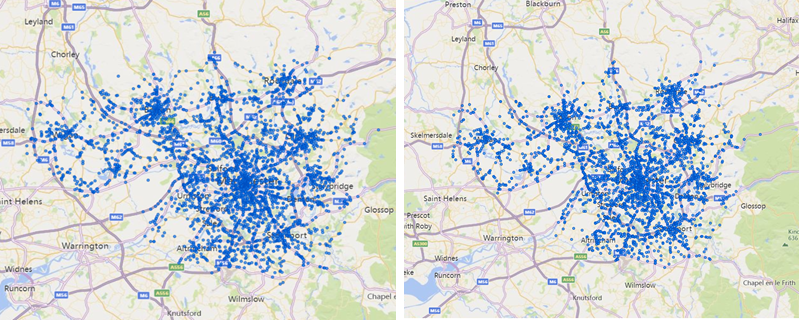

**Insight(6):**
Mật độ xảy ra tai nạn giao thông dày đặc nhất ở thành phố Manchester. Nguyên nhận do thành phố này có mật độ dân cư đông đúc, mật độ giao lộ dày đặc, chằng chịt. 
<br>
Tương tự ở một số khu vực khác, số lượng các vụ tai nạn giao thông đều tập trung ở các giao lộ.

##7. Phân tích tình hình tai nạn giao thông ở các giao lộ

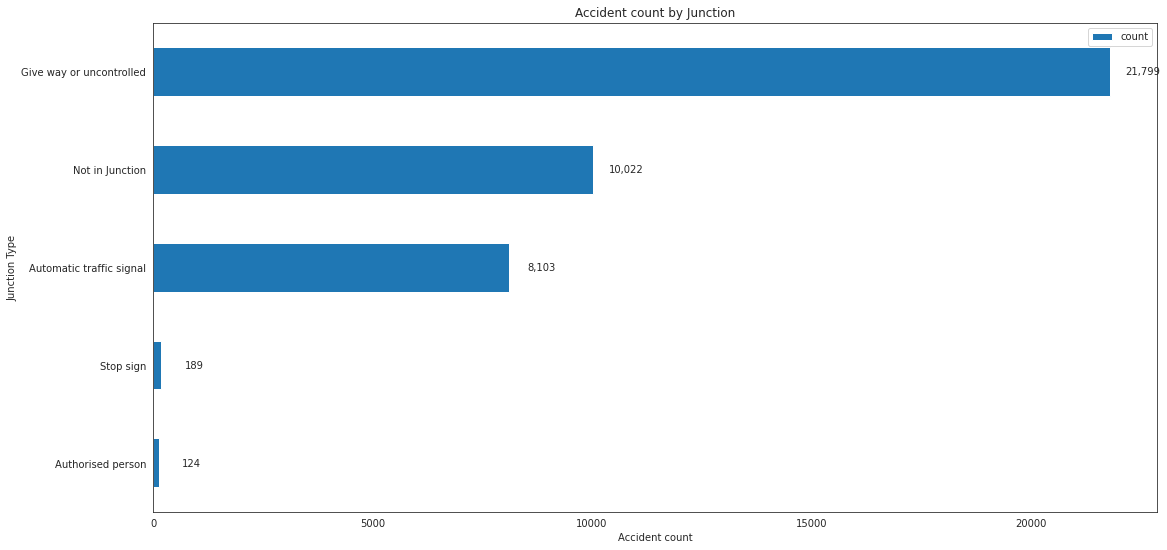

In [35]:
type_junction = {
                0: 'Not in Junction',
                1:'Authorised person',
                2: 'Automatic traffic signal',
                3:'Stop sign',
                4:'Give way or uncontrolled'
}

name_junction = pd.DataFrame(list(type_junction.items())).rename(columns = {0:'JuncType',1:'Name type junction'}).set_index('JuncType')
name_junction

name_junction['count'] = accident_df['JunctionControl'].value_counts().sort_index()
name_junction.set_index('Name type junction', drop=True, inplace=True)

ax = name_junction.sort_values('count').plot(kind='barh', figsize=(18, 9))

plt.xlabel('Accident count')
plt.ylabel('Junction Type')
plt.title('Accident count by Junction')
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds  
    ax.annotate(format(int(width), ','), xy=(left+width+750, bottom+height/2), 
                ha='center', va='center')   
plt.show()

**Nhận xét**: Giao lộ là nơi chủ yếu xảy ra tai nạn ở vùng Great Manchester trong vòng 10 năm từ 2010 tới 2019.

**Insight (7)**:  Chỉ dựa vào ý thức và tính tự giác của người tham gia giao thông thì là chưa đủ để giảm thiểu lượng tai nạn giao thông ở khu vực này mà không cần đến những biện pháp cũng như chế tài cứng rắn hơn.

- Dựa vào số liệu này, ta thấy các vụ tai nạn chủ yếu xảy ra ở giao lộ (chiếm lên tới hơn 75% tổng số vụ được ghi nhận).  
- Dữ liệu địa lý cũng chỉ ra ở khu vực này có rất nhiều giao lộ, vì vậy việc xảy ra nhiều vụ tai nạn ở đây là điều dễ hiểu.  
- Trong số các vụ tai nạn xảy ra ở giao lộ, loại hình giao lộ không có biển báo (nhường đường) xảy ra nhiều vụ tai nạn nhất nguyên nhân có thể là do cơ sở vật chất ở các khu vực này chưa được đầu tư bài bản, dẫn đến việc các phương tiện lưu thông khó khăn, dễ bị va chạm và tai nạn xảy ra.  
- Nhiều thứ 2 là các loại giao lộ có đèn giao thông (tự động), tuy đã có đèn giao thông nhưng số lượng vụ tai nạn giao thông xảy ra ở đây vẫn cao chiếm lên tới 27% tổng số vụ xảy ra ở giao lộ. Từ đây ta có thể thấy được ý thức của các tài xế chưa cao, có thể có các trường hợp vượt đèn đỏ dẫn đến xảy ra tai nạn.
- 2 loại hình cuối cùng có ít trường hợp tai nạn bởi vì đây là đường cấm hoặc là nơi có người trực tiếp điểu khiển giao thông (có thể là công an) nên mọi người tự biết chấp hành, ít gây ra tai nạn.


# Time Series

In [36]:
accident_df['OutputDate'] = pd.to_datetime(accident_df['OutputDate'])

In [37]:
from scipy.stats.mstats import mode

number_of_accidents = pd.DataFrame(accident_df.groupby(pd.Grouper(key='OutputDate', freq='M')).count().iloc[:,1])\
                                  .rename(columns={'Severity': 'Number'})

In [38]:
number_of_accidents.head()

,Number
OutputDate,
2010-01-31,443
2010-02-28,398
2010-03-31,429
2010-04-30,496
2010-05-31,476


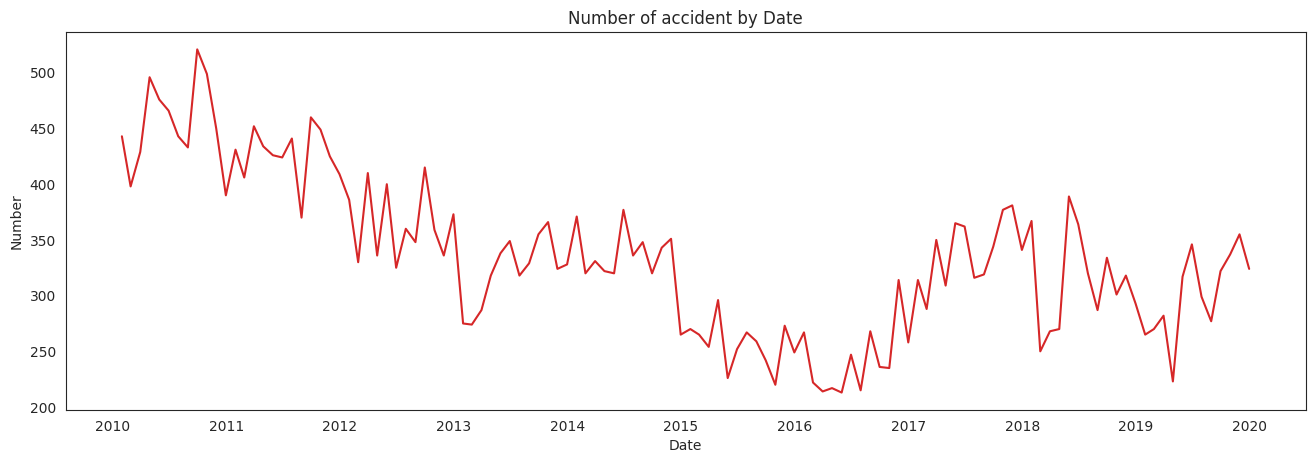

In [39]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(number_of_accidents.index, number_of_accidents['Number'], color='tab:red')
plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Number of accident by Date')
plt.show()

Ta thấy dữ liệu biến động liên tục không có tính xu hướng hay chu kì gì cả.

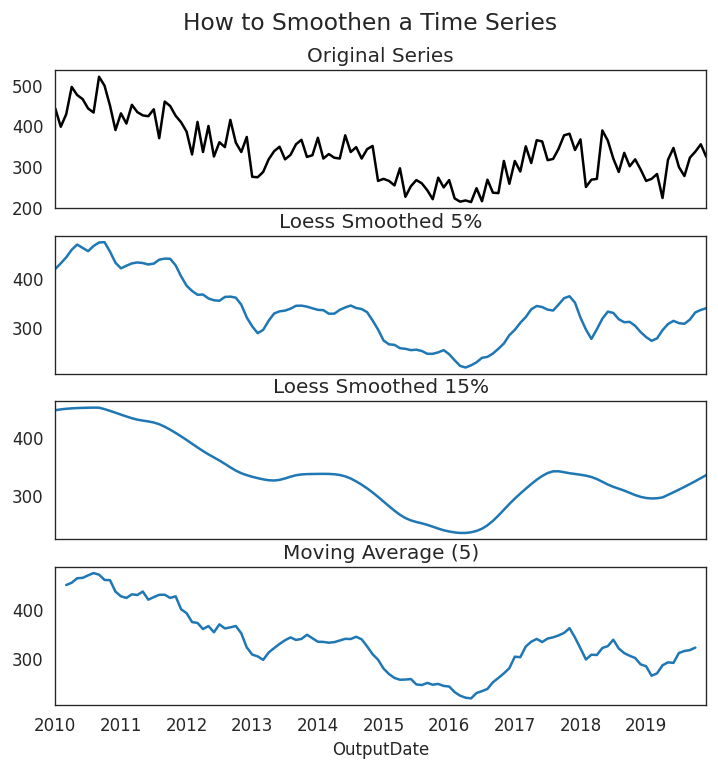

In [40]:
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = number_of_accidents.Number.rolling(5, center=True).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(number_of_accidents.Number, np.arange(len(number_of_accidents.Number)), frac=0.05)[:, 1], index=number_of_accidents.index, columns=['Number'])
df_loess_15 = pd.DataFrame(lowess(number_of_accidents.Number, np.arange(len(number_of_accidents.Number)), frac=0.15)[:, 1], index=number_of_accidents.index, columns=['Number'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
number_of_accidents['Number'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['Number'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['Number'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (5)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

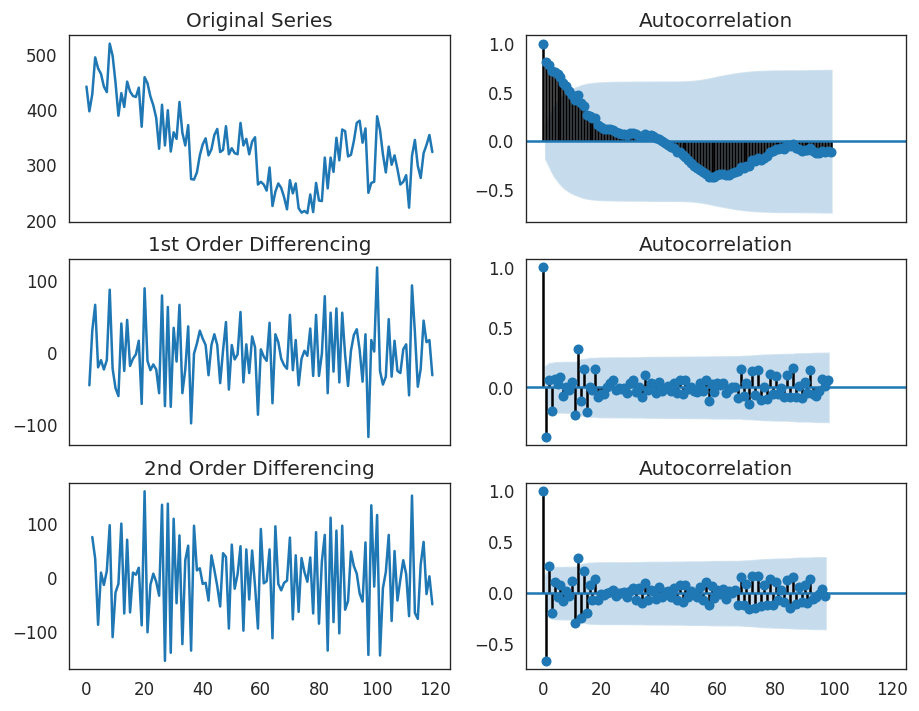

In [41]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(number_of_accidents.Number.tolist()); axes[0, 0].set_title('Original Series')
plot_acf(number_of_accidents.Number.tolist(), ax=axes[0, 1], lags=99)

# 1st Differencing
axes[1, 0].plot(number_of_accidents.Number.diff().tolist()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(number_of_accidents.Number.diff().dropna(), ax=axes[1, 1],lags=98)

# 2nd Differencing
axes[2, 0].plot(number_of_accidents.Number.diff().diff().tolist()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(number_of_accidents.Number.diff().diff().dropna(), ax=axes[2, 1],lags=97)

plt.show()

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(number_of_accidents.rolling(5, center=True).mean().dropna())

def transform_dataset(data, n_backs):
	X, Y = [], []
	for i in range(len(data) - n_backs):
		X.append(data[i:(i + n_backs), 0])
		Y.append(data[i + n_backs, 0])
	return np.array(X), np.array(Y)

n_backs = 3
X, Y = transform_dataset(df, n_backs)
# split into train and test sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size,:], X[train_size:,:]
trainY, testY = Y[:train_size], Y[train_size:]


### LSTM model

In [43]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(1,n_backs),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit(trainX, trainY, epochs=50, batch_size=1,validation_data=(testX, testY), verbose=2)

Epoch 1/50
90/90 - 25s - loss: 0.2299 - val_loss: 0.0400
Epoch 2/50
90/90 - 0s - loss: 0.0263 - val_loss: 0.0042
Epoch 3/50
90/90 - 0s - loss: 0.0092 - val_loss: 0.0037
Epoch 4/50
90/90 - 0s - loss: 0.0078 - val_loss: 0.0036
Epoch 5/50
90/90 - 0s - loss: 0.0074 - val_loss: 0.0036
Epoch 6/50
90/90 - 0s - loss: 0.0073 - val_loss: 0.0037
Epoch 7/50
90/90 - 0s - loss: 0.0064 - val_loss: 0.0038
Epoch 8/50
90/90 - 0s - loss: 0.0064 - val_loss: 0.0036
Epoch 9/50
90/90 - 0s - loss: 0.0053 - val_loss: 0.0040
Epoch 10/50
90/90 - 0s - loss: 0.0049 - val_loss: 0.0040
Epoch 11/50
90/90 - 0s - loss: 0.0041 - val_loss: 0.0049
Epoch 12/50
90/90 - 0s - loss: 0.0043 - val_loss: 0.0052
Epoch 13/50
90/90 - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 14/50
90/90 - 0s - loss: 0.0037 - val_loss: 0.0039
Epoch 15/50
90/90 - 0s - loss: 0.0040 - val_loss: 0.0034
Epoch 16/50
90/90 - 0s - loss: 0.0034 - val_loss: 0.0036
Epoch 17/50
90/90 - 0s - loss: 0.0028 - val_loss: 0.0050
Epoch 18/50
90/90 - 0s - loss: 0.0030 -

In [44]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

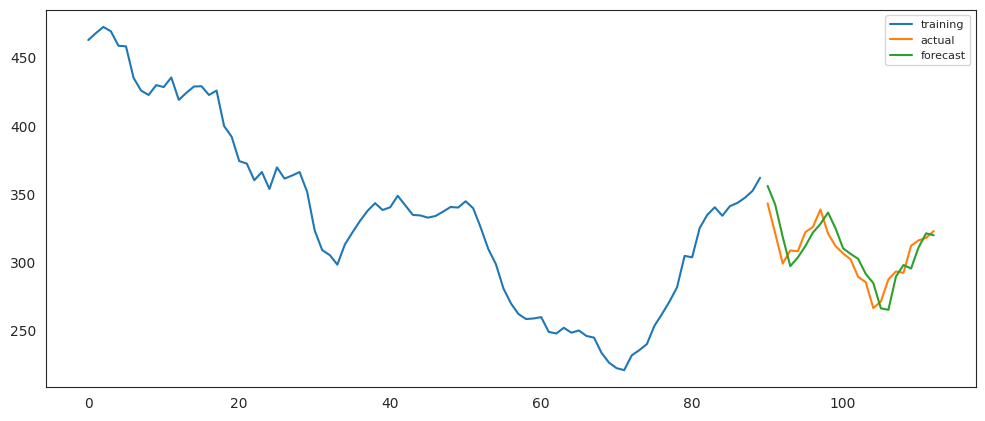

In [45]:
testPredictPlot = np.empty_like(Y.reshape(-1,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):, :] = testPredict

testPlot = np.empty_like(Y.reshape(-1,1))
testPlot[:, :] = np.nan
testPlot[len(trainPredict):, :] = testY.T

plt.figure(figsize=(12,5), dpi=100)
plt.plot(trainY.T, label='training')
plt.plot(testPlot, label='actual')
plt.plot(testPredictPlot, label='forecast')
plt.legend(loc='upper right', fontsize=8)

plt.show()

In [46]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
model.fit(X, Y, epochs=50, batch_size=16, verbose=2)

Epoch 1/50
8/8 - 3s - loss: 0.0015
Epoch 2/50
8/8 - 0s - loss: 0.0015
Epoch 3/50
8/8 - 0s - loss: 0.0016
Epoch 4/50
8/8 - 0s - loss: 0.0016
Epoch 5/50
8/8 - 0s - loss: 0.0016
Epoch 6/50
8/8 - 0s - loss: 0.0015
Epoch 7/50
8/8 - 0s - loss: 0.0015
Epoch 8/50
8/8 - 0s - loss: 0.0015
Epoch 9/50
8/8 - 0s - loss: 0.0014
Epoch 10/50
8/8 - 0s - loss: 0.0015
Epoch 11/50
8/8 - 0s - loss: 0.0014
Epoch 12/50
8/8 - 0s - loss: 0.0015
Epoch 13/50
8/8 - 0s - loss: 0.0015
Epoch 14/50
8/8 - 0s - loss: 0.0014
Epoch 15/50
8/8 - 0s - loss: 0.0014
Epoch 16/50
8/8 - 0s - loss: 0.0014
Epoch 17/50
8/8 - 0s - loss: 0.0014
Epoch 18/50
8/8 - 0s - loss: 0.0014
Epoch 19/50
8/8 - 0s - loss: 0.0015
Epoch 20/50
8/8 - 0s - loss: 0.0015
Epoch 21/50
8/8 - 0s - loss: 0.0014
Epoch 22/50
8/8 - 0s - loss: 0.0014
Epoch 23/50
8/8 - 0s - loss: 0.0014
Epoch 24/50
8/8 - 0s - loss: 0.0014
Epoch 25/50
8/8 - 0s - loss: 0.0014
Epoch 26/50
8/8 - 0s - loss: 0.0015
Epoch 27/50
8/8 - 0s - loss: 0.0014
Epoch 28/50
8/8 - 0s - loss: 0.0015
E

## Dự đoán số vụ tai nạn trong năm 2020


In [51]:
def forecast(data, n_months):
  results=[]
  X = np.array([data[-n_backs:]])
  for i in range(n_months):
    Y = np.reshape(X,(X.shape[0], 1, X.shape[1]))
    results.append(model.predict(Y))
    X = np.concatenate((X, results[-1]), axis=1)
    X = X[0][1:].reshape(1,-1)
  return results

In [52]:
n_months = 12
forecasts = np.array(forecast(Y,n_months)).reshape(n_months,1)
forecasts = scaler.inverse_transform(forecasts)

In [53]:
forecasts

array([[324.51596],
       [326.43274],
       [327.1333 ],
       [327.7792 ],
       [328.00333],
       [328.1648 ],
       [328.1902 ],
       [328.19235],
       [328.15933],
       [328.12552],
       [328.0888 ],
       [328.05835]], dtype=float32)

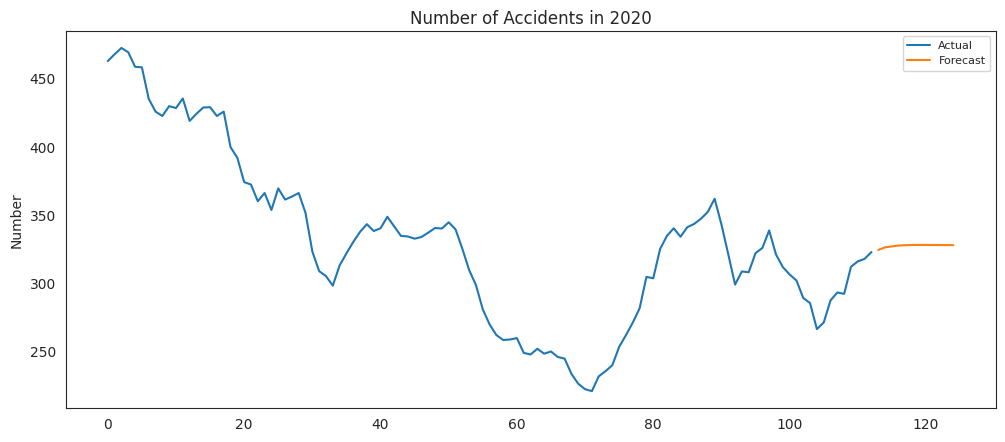

In [54]:
forecastsPlot = np.empty([Y.shape[0]+n_months,1])
forecastsPlot[:, :] = np.nan
forecastsPlot[len(Y):, :] = forecasts

plt.figure(figsize=(12,5), dpi=100)
plt.plot(scaler.inverse_transform([Y]).T, label='Actual')
plt.plot(forecastsPlot, label='Forecast')
plt.ylabel('Number')
plt.title("Number of Accidents in 2020")
plt.legend(loc='upper right', fontsize=8)
plt.show()

Sử dụng Tableau dự đoán số vụ tai nạn giao thông trong tương lai gần (năm kế tiếp 2020)

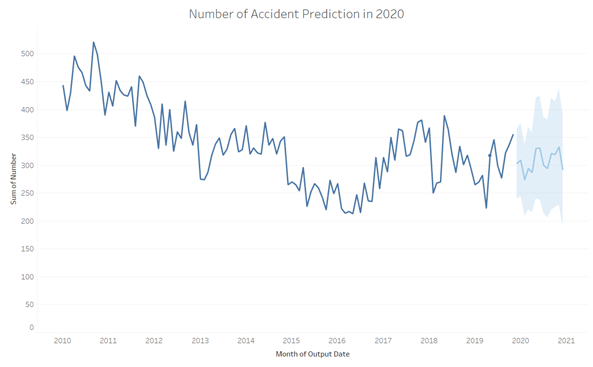